In [1]:
%reload_ext autoreload
%autoreload 2

from typing import Callable, Dict

import os
import datetime as dt
import pytz
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%config Inlinebackend.figure_format = 'retina'

In [2]:
# Constants

# Filepath
FILE_PATH = "/Users/lukasmalms/Desktop/DataScience/GitHub/german-power-grid/data/de-50hertz-demand-data.csv"

# Timezone
UTC = pytz.utc

# Month to int
MONTHS_OF_THE_YEAR = dict(zip(
    ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"],
    [i for i in range(1, 13)]
))

# Leap years
LEAP_YEARS = [2004, 2008, 2012, 2016, 2020]

# Days per month
def get_days_per_month() -> Callable[[int], Dict[str, int]]:
    
    def days_per_month(year: int) -> Dict[str, int]:
        return dict(zip(
            ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"],
            [31, (29 if year in LEAP_YEARS else 28), 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        ))

    return days_per_month

DAYS_PER_MONTH = get_days_per_month()

In [3]:
# Import data
df = pd.read_csv(
    filepath_or_buffer=FILE_PATH, 
    index_col="timestamp",
    parse_dates=True
).astype(
    {"quantity": float}
).rename(columns=
    {"quantity": "local_demand"}
)

# Set frequency
df.index.freq = df.index.inferred_freq

# View head
df.head()

,local_demand
timestamp,
2014-12-31 23:00:00+00:00,9275.0
2014-12-31 23:15:00+00:00,9240.0
2014-12-31 23:30:00+00:00,9204.0
2014-12-31 23:45:00+00:00,9127.0
2015-01-01 00:00:00+00:00,9080.0


# EDA

### Missing data?

In [4]:
print(df.reset_index().isna().any(axis=0))

timestamp       False
local_demand    False
dtype: bool


### Duplicate data?

In [5]:
df.loc[df.index.duplicated()]

,local_demand
timestamp,


### Demand data for selected months in 2019

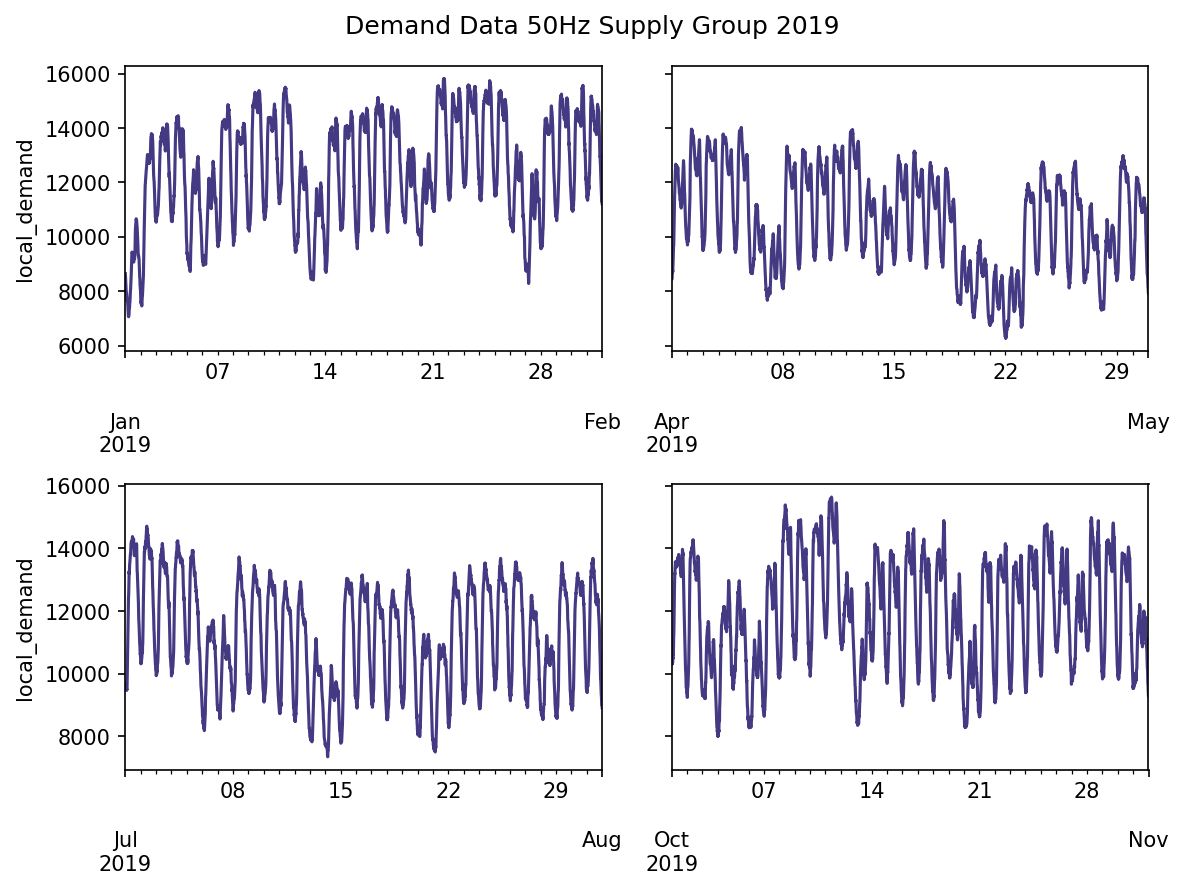

In [6]:
fig, ax = plt.subplots(2, 2, dpi=150, figsize=(8, 6), sharey="row")
cmap = sns.color_palette("viridis", n_colors=5)

date_range = pd.date_range(
    start=UTC.localize(dt.datetime(2019, 1, 1)),
    end=UTC.localize(dt.datetime(2019, 12, 1)),
    freq="MS"
)

for i, (start, end) in enumerate(zip(date_range[::3], date_range[1::3])):
    
    # Slice df
    df_slice = df.loc[(df.index >= start) & (df.index <= end)]
    
    # Plot
    ax[i//2, i%2] = df_slice.plot(ax=ax[i//2, i%2], legend=False, c=cmap[0])
    ax[i//2, i%2].set_xlabel("")
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel("local_demand")


fig.suptitle("Demand Data 50Hz Supply Group 2019")        
fig.tight_layout();

### Demand data for select months in 2020 

/Users/lukasmalms/Desktop/DataScience/venvs/german-power-grid/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


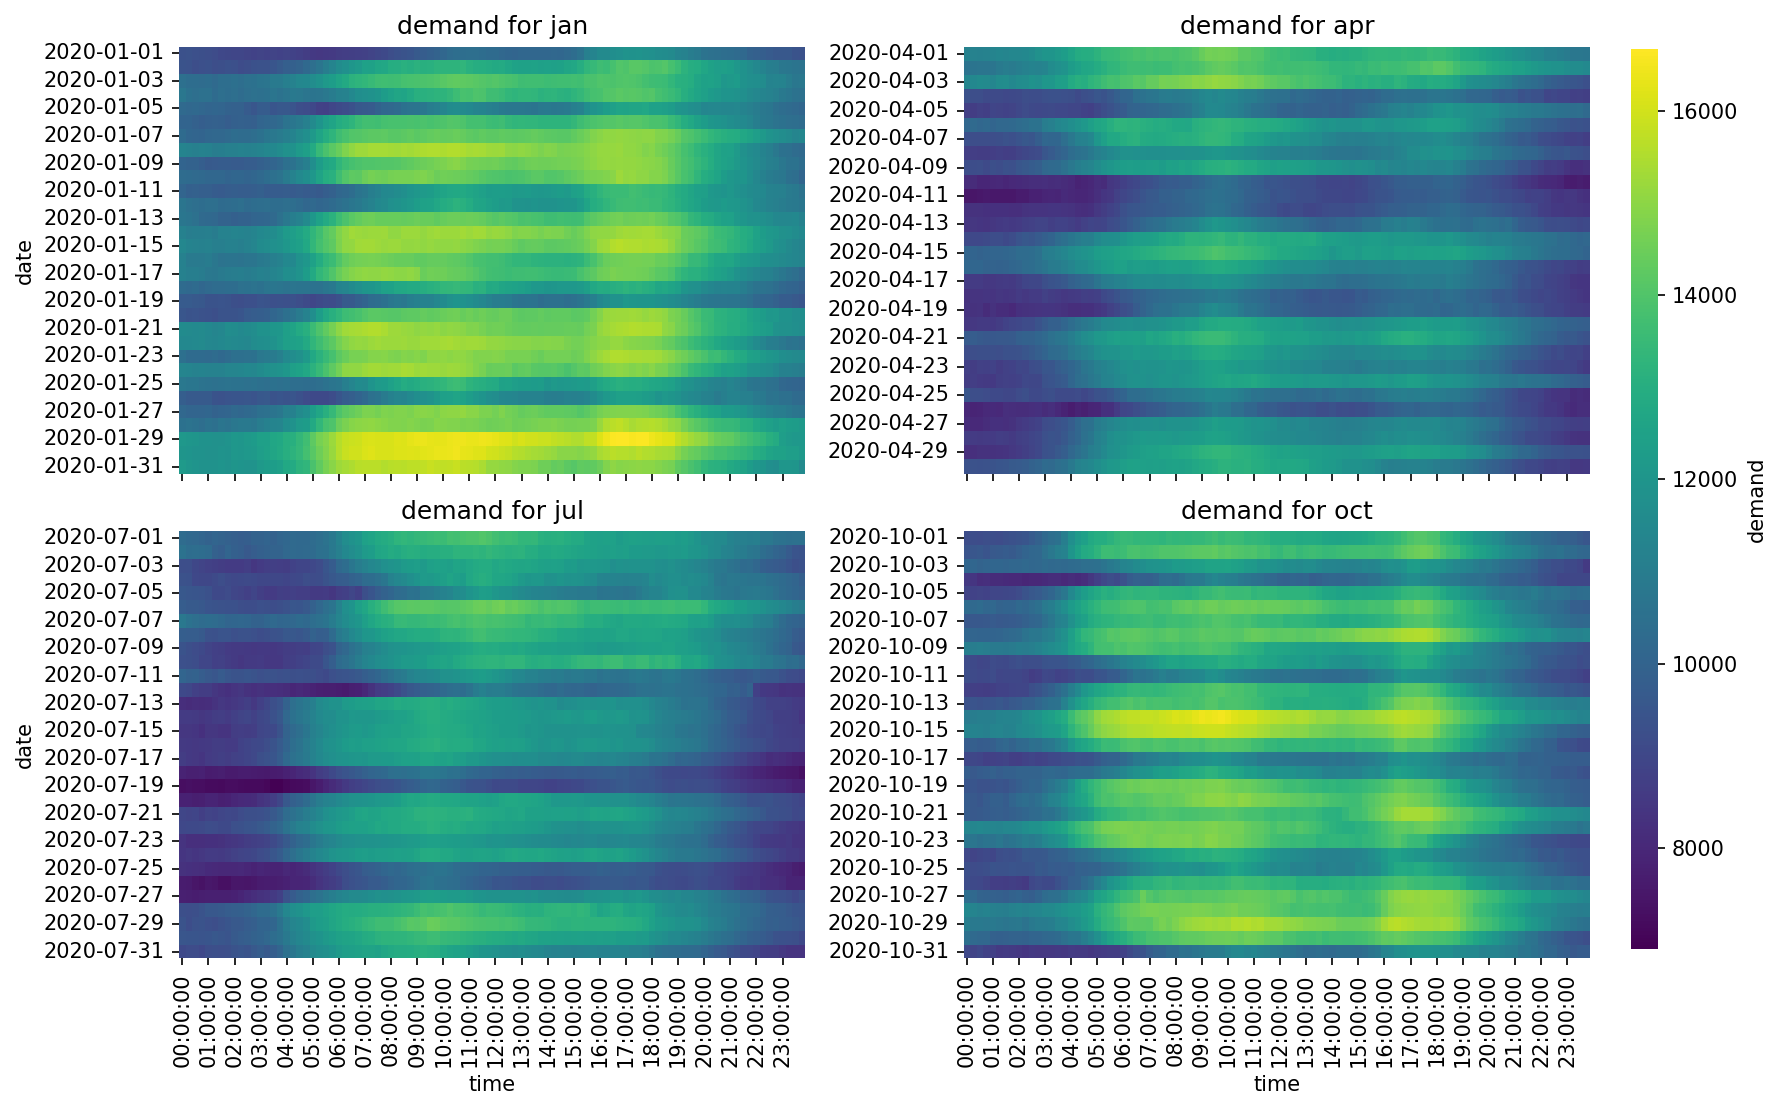

In [7]:
def plot_heat_map(year: int, month: str, **kwargs) -> plt.Axes:
    
    # Check month is valid
    assert month in MONTHS_OF_THE_YEAR
    
    # Define start and end dates
    days_in_month = DAYS_PER_MONTH(year)[month]
    month = MONTHS_OF_THE_YEAR[month]
    start = dt.datetime(year, month, 1, 0, 0, 0)
    end = dt.datetime(year, month, days_in_month, 23, 45, 0)
    
    # Slice df over month
    df_slice = df.loc[start: end]
    df_slice = df_slice.assign(date=df_slice.index.date, time=df_slice.index.time)
    
    # Create pivot table
    df_pivot = df_slice.pivot(index="date", columns="time", values="local_demand")

    # Plot heatmap
    return sns.heatmap(df_pivot, **kwargs)

year = 2020
months = ["jan", "apr", "jul", "oct"]

fig, ax = plt.subplots(2, 2, figsize=(12, 7.5), dpi=150, sharex=True)
cbar_ax = fig.add_axes([.91, 0.15, .015, .8])

# Get max and min values for selected months
min_values = []
max_values = []

for month in months:
    days_in_month = DAYS_PER_MONTH(year)[month]
    month = MONTHS_OF_THE_YEAR[month]
    start = dt.datetime(year, month, 1, 0, 0, 0)
    end = dt.datetime(year, month, days_in_month, 23, 45, 0)
    
    min_values.append(df.loc[start: end]["local_demand"].min())
    max_values.append(df.loc[start: end]["local_demand"].max())

for i, month in enumerate(months):
    plot_heat_map(
        year=year, 
        month=month, 
        ax=ax[i//2, i%2], 
        cbar=i==0,  # Only plot cbar for the first heatmap
        cbar_ax=None if i else cbar_ax,  # and plot it on this axis
        cbar_kws={"label": "demand"},
        vmin=np.min(min_values),
        vmax=np.max(max_values),
        cmap=sns.color_palette("viridis", as_cmap=True)
    )
    ax[i//2, i%2].set_title(f"demand for {month}")
    if i%2:
        ax[i//2, i%2].set_ylabel("")
    if not i//2:
        ax[i//2, i%2].set_xlabel("")
        
fig.tight_layout(rect=[0., 0., 0.9, 1])

### Demand grouped by time of day & autocorrelation

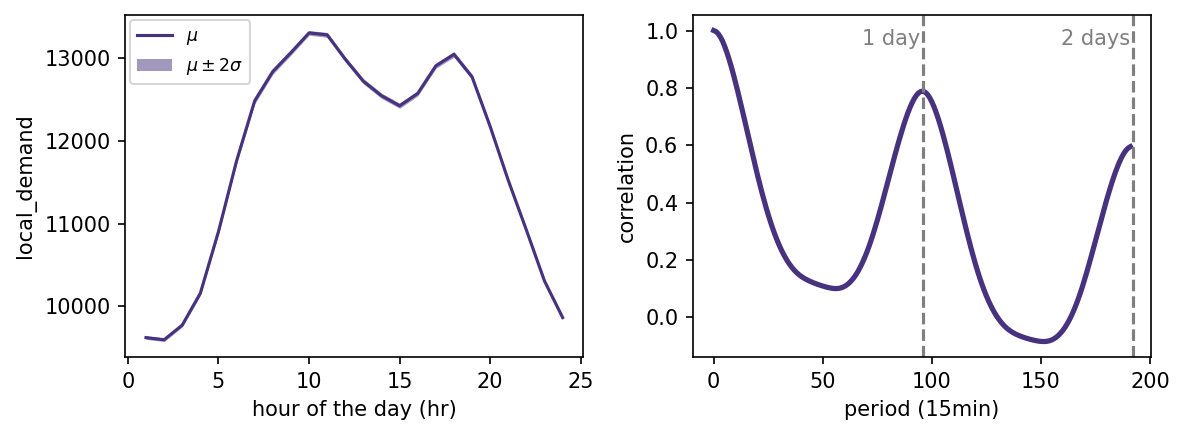

In [8]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 3))
cmap = sns.color_palette("viridis")

# Average consumption grouped by time of day
hourly_consumption_stats = df.groupby(df.index.hour).agg({
    "local_demand": ["mean", "sem"]
})
mean = np.array(hourly_consumption_stats[("local_demand", "mean")])
err = np.array(hourly_consumption_stats[("local_demand", "sem")])
ax[0].plot(np.arange(1, 25), mean, label="$\mu$", color=cmap[0])
ax[0].fill_between(
    np.arange(1, 25), mean-2*err, mean+2*err, label="$\mu\pm2\sigma$", alpha=0.5, lw=0, color=cmap[0]
)

ax[0].legend(loc=2, fontsize="small", borderaxespad=.3)
ax[0].set_xlabel("hour of the day (hr)")
ax[0].set_ylabel("local_demand")

# Autocorrelation
max_lags = 2 * 24 * 4  # 2 days 
ax[1].plot(
    np.arange(max_lags),
    np.array([df["local_demand"].autocorr(lag=lag) for lag in range(max_lags)]),
    lw=2.5,
    color=cmap[0]
)

ax[1].axvline(1*24*4, color="tab:grey", lw=1.5, ls="--")
ax[1].axvline(2*24*4, color="tab:grey", lw=1.5, ls="--")
ax[1].annotate("1 day", (1*24*4-28, 0.95), color="tab:grey")
ax[1].annotate("2 days", (2*24*4-33, 0.95), color="tab:grey")
ax[1].set_xlabel("period (15min)")
ax[1].set_ylabel("correlation")

fig.tight_layout();

### Fourier analysis

In [9]:
from scipy import fftpack
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression

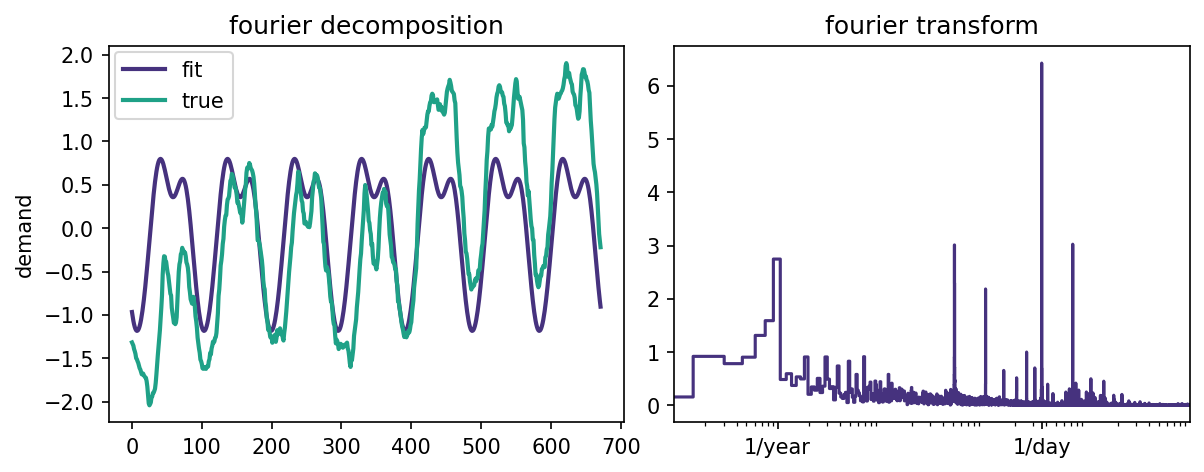

In [10]:
period = 24 * 60 * 60  # in seconds (from autocorrelation plot)
t_s = np.array(3600*df.index.hour + 60*df.index.minute + df.index.second)
for i in range(1, 4):  # plot the first 3 fourier terms
    df.loc[:, f"cos_{i}"] = np.sin((2*np.pi*i*t_s)/period)
    df.loc[:, f"sin_{i}"] = np.cos((2*np.pi*i*t_s)/period)


# Does a linear combination of these features resemble the time series?
features = [f"sin_{i}" for i in range(1, 4)] + [f"cos_{i}" for i in range(1, 4)]
X = np.array(df[features])
y = np.array(df["local_demand"])
y = (y - np.mean(y)) / np.std(y)
lr = LinearRegression().fit(X, y)
y_hat = lr.predict(X)


fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 3.25))
cmap = sns.color_palette("viridis")
n_samples = 7*4*24
ax[0].plot(y_hat[:n_samples], label="fit", color=cmap[0], lw=2)
ax[0].plot(y[:n_samples], label="true", color=cmap[3], lw=2)
ax[0].legend(fontsize="medium", borderaxespad=.3)
ax[0].set_ylabel("demand")
ax[0].set_title("fourier decomposition")

# Fourier transform 
sampling_rate = 4 * 24 * 365.2524  # number of obs per year
years_in_data = len(y) / sampling_rate
t = (np.arange(0, len(y)) / years_in_data)
y_fft = fftpack.fft(y)

ax[1].step(t, np.abs(y_fft/np.max(y_fft)), color=cmap[0], lw=1.5)
ax[1].set_xscale("log")
ax[1].set_xlim([0.1, 10000])
ax[1].set_xticks([1, 365.25])
ax[1].set_xticklabels(["1/year", "1/day"])
ax[1].set_title("fourier transform")

fig.tight_layout();